<a href="https://colab.research.google.com/github/Kontuzhenyi/AI_python/blob/main/%D0%B0%D0%B2%D1%82%D0%BE%D1%8D%D0%BD%D0%BA%D0%BE%D0%B4%D0%B5%D1%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import pickle

from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader


import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
#LABELS = ["Normal", "Fraud"]

Датасет об интернет трафике. Целевой класс в 48 столбце. 0 - нормальный трафик, 1 - вредоносный трафик (DoS, DDoS, черви, эксплойты)

Скачиваем файлы

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mrwellsdavid/unsw-nb15")
print("Path to dataset files:", path)

100%|██████████| 149M/149M [00:01<00:00, 79.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mrwellsdavid/unsw-nb15/versions/1


Находим нужный csv файл и загружаем его в DataFrame

In [3]:
import os

# Получение списка файлов в папке
files = os.listdir(path)
print("Files in dataset:", files)

# Выбираем файл "UNSW_NB15_1.csv"
csv_file = [f for f in files if f.endswith("UNSW-NB15_1.csv")][0]
file_path = os.path.join(path, csv_file)
print("Using file:", file_path)

# Загрузка данных в DataFrame
df = pd.read_csv(file_path)
print("Dataset shape:", df.shape)
df.columns = range(df.shape[1])  # Заменяем названия столбцов на числа от 0 до n-1
print("Columns:", df.columns)

Files in dataset: ['UNSW-NB15_4.csv', 'UNSW-NB15_1.csv', 'UNSW_NB15_testing-set.csv', 'UNSW_NB15_training-set.csv', 'UNSW-NB15_3.csv', 'UNSW-NB15_LIST_EVENTS.csv', 'NUSW-NB15_features.csv', 'UNSW-NB15_2.csv']
Using file: /root/.cache/kagglehub/datasets/mrwellsdavid/unsw-nb15/versions/1/UNSW-NB15_1.csv


<ipython-input-3-b36cabcea844>:13: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Dataset shape: (700000, 49)
Columns: RangeIndex(start=0, stop=49, step=1)


In [4]:
df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,...,0,2,4,2,3,1,1,2,NaN,0
1,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,...,0,12,8,1,2,2,1,1,NaN,0
2,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,...,0,6,9,1,1,1,1,1,NaN,0
3,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,...,0,7,9,1,1,1,1,1,NaN,0
4,59.166.0.0,32119,149.171.126.9,111,udp,CON,0.078339,568,312,31,...,0,2,4,2,3,1,1,2,NaN,0
5,59.166.0.6,2142,149.171.126.4,53,udp,CON,0.001134,132,164,31,...,0,12,7,1,2,2,1,1,NaN,0
6,10.40.182.3,0,10.40.182.3,0,arp,INT,0.000000,46,0,0,...,0,2,2,2,2,2,2,2,NaN,0
7,59.166.0.5,40726,149.171.126.6,53,udp,CON,0.001126,146,178,31,...,0,6,7,3,1,1,1,1,NaN,0
8,59.166.0.7,12660,149.171.126.4,53,udp,CON,0.001167,132,164,31,...,0,6,7,2,1,1,1,1,NaN,0
9,10.40.170.2,0,10.40.170.2,0,arp,INT,0.000000,46,0,0,...,0,2,2,2,2,2,2,2,NaN,0


В датасете присутствуют пустый ячейки

In [5]:
# Количество пустых ячеек
np.count_nonzero(df.isnull().sum(axis= 1).values)

677785

In [6]:
# Подсчёт количества пустых ячеек в каждом столбце
missing_values = df.isna().sum()

# Вывод результата
print(missing_values)

0          0
1          0
2          0
3          0
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11         0
12         0
13         0
14         0
15         0
16         0
17         0
18         0
19         0
20         0
21         0
22         0
23         0
24         0
25         0
26         0
27         0
28         0
29         0
30         0
31         0
32         0
33         0
34         0
35         0
36         0
37         0
38         0
39         0
40         0
41         0
42         0
43         0
44         0
45         0
46         0
47    677785
48         0
dtype: int64


Принимаю решение удалить 47 столбец, так как 97% ячеек содержат пропуск

In [7]:
df = df.drop([47], axis=1)

Теперь пропусков нет

In [8]:
np.count_nonzero(df.isnull().sum(axis= 1).values)

0

Необходимо перевести категориальные столбцы в числовые

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 48 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       700000 non-null  object 
 1   1       700000 non-null  object 
 2   2       700000 non-null  object 
 3   3       700000 non-null  object 
 4   4       700000 non-null  object 
 5   5       700000 non-null  object 
 6   6       700000 non-null  float64
 7   7       700000 non-null  int64  
 8   8       700000 non-null  int64  
 9   9       700000 non-null  int64  
 10  10      700000 non-null  int64  
 11  11      700000 non-null  int64  
 12  12      700000 non-null  int64  
 13  13      700000 non-null  object 
 14  14      700000 non-null  float64
 15  15      700000 non-null  float64
 16  16      700000 non-null  int64  
 17  17      700000 non-null  int64  
 18  18      700000 non-null  int64  
 19  19      700000 non-null  int64  
 20  20      700000 non-null  int64  
 21  21      70

Необходимая часть

In [10]:
df[1] = df[1].astype(str)
df[3] = df[3].astype(str)

Перевод столбцов в числовой тип

In [11]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
# Список категориальных столбцов
categorical_columns = [0, 1, 2, 3, 4, 5, 13]
for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 48 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       700000 non-null  int64  
 1   1       700000 non-null  int64  
 2   2       700000 non-null  int64  
 3   3       700000 non-null  int64  
 4   4       700000 non-null  int64  
 5   5       700000 non-null  int64  
 6   6       700000 non-null  float64
 7   7       700000 non-null  int64  
 8   8       700000 non-null  int64  
 9   9       700000 non-null  int64  
 10  10      700000 non-null  int64  
 11  11      700000 non-null  int64  
 12  12      700000 non-null  int64  
 13  13      700000 non-null  int64  
 14  14      700000 non-null  float64
 15  15      700000 non-null  float64
 16  16      700000 non-null  int64  
 17  17      700000 non-null  int64  
 18  18      700000 non-null  int64  
 19  19      700000 non-null  int64  
 20  20      700000 non-null  int64  
 21  21      70

In [13]:
df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,48
0,30,26018,25,239,120,2,0.036133,528,304,31,...,0,0,2,4,2,3,1,1,2,0
1,36,5087,23,45600,120,2,0.001119,146,178,31,...,0,0,12,8,1,2,2,1,1,0
2,35,28513,21,45600,120,2,0.001209,132,164,31,...,0,0,6,9,1,1,1,1,1,0
3,33,43623,6,45600,120,2,0.001169,146,178,31,...,0,0,7,9,1,1,1,1,1,0
4,30,24321,25,1159,120,2,0.078339,568,312,31,...,0,0,2,4,2,3,1,1,2,0
5,36,12547,20,45600,120,2,0.001134,132,164,31,...,0,0,12,7,1,2,2,1,1,0
6,2,1,1,1,6,6,0.000000,46,0,0,...,0,0,2,2,2,2,2,2,2,0
7,35,33789,22,45600,120,2,0.001126,146,178,31,...,0,0,6,7,3,1,1,1,1,0
8,37,2908,20,45600,120,2,0.001167,132,164,31,...,0,0,6,7,2,1,1,1,1,0
9,0,1,0,1,6,6,0.000000,46,0,0,...,0,0,2,2,2,2,2,2,2,0


Необходимо делать нормализацию

In [14]:
from sklearn.preprocessing import MinMaxScaler

# Нормализация
# Список всех столбцов, кроме столбца 48
columns_to_normalize = [col for col in df.columns if col != 48]
scaler = MinMaxScaler()
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 48 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       700000 non-null  float64
 1   1       700000 non-null  float64
 2   2       700000 non-null  float64
 3   3       700000 non-null  float64
 4   4       700000 non-null  float64
 5   5       700000 non-null  float64
 6   6       700000 non-null  float64
 7   7       700000 non-null  float64
 8   8       700000 non-null  float64
 9   9       700000 non-null  float64
 10  10      700000 non-null  float64
 11  11      700000 non-null  float64
 12  12      700000 non-null  float64
 13  13      700000 non-null  float64
 14  14      700000 non-null  float64
 15  15      700000 non-null  float64
 16  16      700000 non-null  float64
 17  17      700000 non-null  float64
 18  18      700000 non-null  float64
 19  19      700000 non-null  float64
 20  20      700000 non-null  float64
 21  21      70

In [16]:
df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,48
0,0.769231,0.403130,0.581395,0.003841,0.895522,0.133333,4.112267e-06,0.000039,0.000021,0.121569,...,0.0,0.0,0.023256,0.073171,0.02439,0.040816,0.000000,0.000000,0.027027,0
1,0.923077,0.078819,0.534884,0.732872,0.895522,0.133333,1.273525e-07,0.000011,0.000012,0.121569,...,0.0,0.0,0.255814,0.170732,0.00000,0.020408,0.028571,0.000000,0.000000,0
2,0.897436,0.441788,0.488372,0.732872,0.895522,0.133333,1.375953e-07,0.000010,0.000011,0.121569,...,0.0,0.0,0.116279,0.195122,0.00000,0.000000,0.000000,0.000000,0.000000,0
3,0.846154,0.675906,0.139535,0.732872,0.895522,0.133333,1.330429e-07,0.000011,0.000012,0.121569,...,0.0,0.0,0.139535,0.195122,0.00000,0.000000,0.000000,0.000000,0.000000,0
4,0.769231,0.376836,0.581395,0.018627,0.895522,0.133333,8.915697e-06,0.000042,0.000021,0.121569,...,0.0,0.0,0.023256,0.073171,0.02439,0.040816,0.000000,0.000000,0.027027,0
5,0.923077,0.194407,0.465116,0.732872,0.895522,0.133333,1.290596e-07,0.000010,0.000011,0.121569,...,0.0,0.0,0.255814,0.146341,0.00000,0.020408,0.028571,0.000000,0.000000,0
6,0.051282,0.000015,0.023256,0.000016,0.044776,0.400000,0.000000e+00,0.000003,0.000000,0.000000,...,0.0,0.0,0.023256,0.024390,0.02439,0.020408,0.028571,0.030303,0.027027,0
7,0.897436,0.523536,0.511628,0.732872,0.895522,0.133333,1.281491e-07,0.000011,0.000012,0.121569,...,0.0,0.0,0.116279,0.146341,0.04878,0.000000,0.000000,0.000000,0.000000,0
8,0.948718,0.045057,0.465116,0.732872,0.895522,0.133333,1.328153e-07,0.000010,0.000011,0.121569,...,0.0,0.0,0.116279,0.146341,0.02439,0.000000,0.000000,0.000000,0.000000,0
9,0.000000,0.000015,0.000000,0.000016,0.044776,0.400000,0.000000e+00,0.000003,0.000000,0.000000,...,0.0,0.0,0.023256,0.024390,0.02439,0.020408,0.028571,0.030303,0.027027,0


Датасет большой и столбцов много, поэтому через тепловую карту выберем только часть столбцов

In [17]:
correlation_matrix = df.corr()

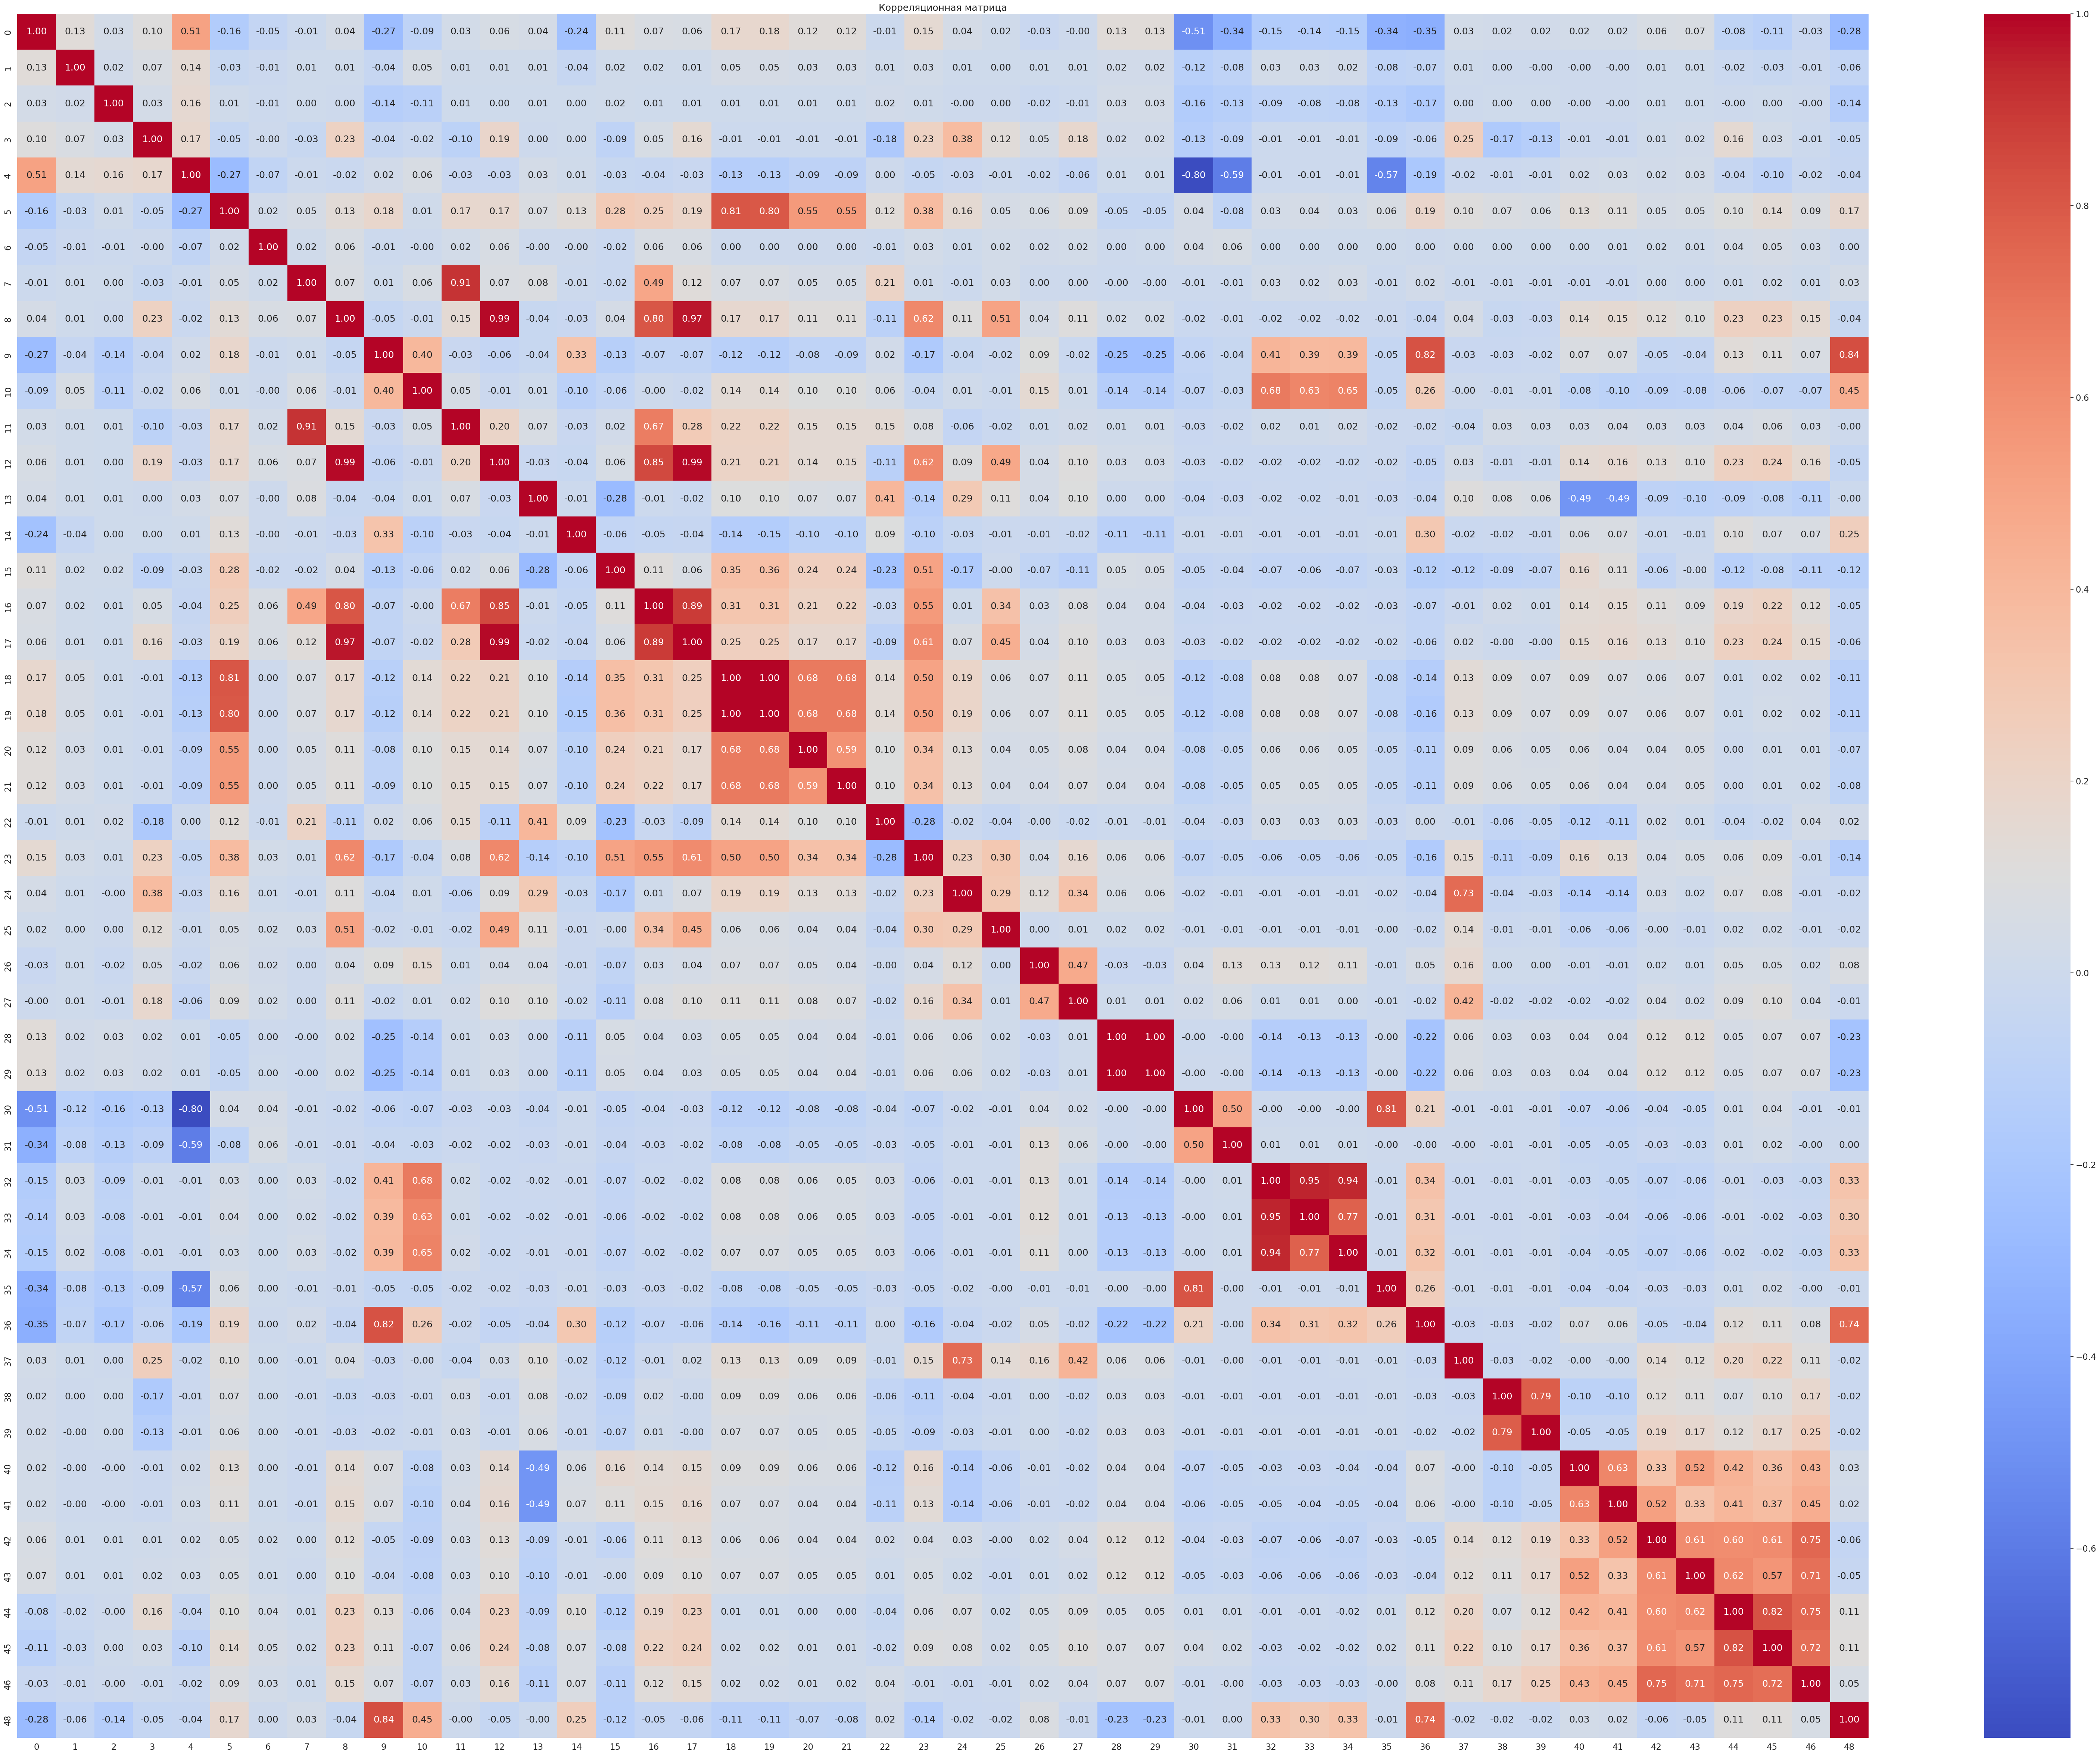

In [18]:
# Создание тепловой карты
plt.figure(figsize=(80, 60))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Корреляционная матрица")
plt.show()

Я выбрыл 0, 9, 10, 14, 23, 29, 32 и 36 столбец

In [19]:
df = df[[0, 9, 10, 14, 23, 29, 32, 36, 48]]

In [20]:
df.head(10)

,0,9,10,14,23,29,32,36,48
0,0.769231,0.121569,0.114173,0.000017,0.050667,0.000000,0.0,0.000000,0
1,0.923077,0.121569,0.114173,0.000099,0.059333,0.000000,0.0,0.000000,0
2,0.897436,0.121569,0.114173,0.000083,0.054667,0.000000,0.0,0.000000,0
3,0.846154,0.121569,0.114173,0.000095,0.059333,0.000000,0.0,0.000000,0
4,0.769231,0.121569,0.114173,0.000008,0.052000,0.000000,0.0,0.000000,0
5,0.923077,0.121569,0.114173,0.000088,0.054667,0.000000,0.0,0.000000,0
6,0.051282,0.000000,0.000000,0.000000,0.000000,0.000035,0.0,0.333333,0
7,0.897436,0.121569,0.114173,0.000098,0.059333,0.000035,0.0,0.000000,0
8,0.948718,0.121569,0.114173,0.000086,0.054667,0.000035,0.0,0.000000,0
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000035,0.0,0.333333,0


В целевой переменной, о нормальном трафике 677785 записей и 22215 о вредоносном трафике

In [21]:
# Получение уникальных значений в столбце 48
value_counts = df[48].value_counts()

# Вывод уникальных значений
print(value_counts)

48
0    677785
1     22215
Name: count, dtype: int64


Разделяем данные на тестовую и обучающую выборку. В тестовой будут записи только о нормальном трафике

In [22]:
# Разделение данных
X_train, X_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)

# Тренировочные данные
X_train = X_train[X_train[48] == 0]
y_train = X_train[48]
X_train = X_train.drop([48], axis=1)

# Тестовые данные
y_test = X_test[48]
X_test = X_test.drop([48], axis=1)

# Преобразование данных в numpy для PyTorch
X_train = X_train.values
X_test = X_test.values
y_test = y_test.values

In [23]:
# Создание DataLoader
minibatch_size = 50
train_loader = data_utils.DataLoader(torch.tensor(X_train, dtype=torch.float32), batch_size=minibatch_size, shuffle=True)
test_loader = data_utils.DataLoader(torch.tensor(X_test, dtype=torch.float32), batch_size=1, shuffle=False)

Определяем модель автоэнкодера. У меня будет 3 слоя, на первом 16 нейронов, на втором 8, а на третьем 4

In [24]:
# Определение автоэнкодера
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(X_train.shape[1], 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 4),  # Ближе к компактному представлению
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, X_train.shape[1]),
            nn.Sigmoid()  # Используем Sigmoid, если данные в диапазоне [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Инициализируем модель. Я буду её обучать на 5 эпохах

In [25]:
# Инициализация модели
model = Autoencoder()
criterion = nn.MSELoss() # Функция потерь. Вычисляет среднеквадратичную ошибку модели. Между предсказанными и реальными
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5) # Оптимизирует параметры модели
# model.parameters() - передает веса и смещения которые будут обновляться во время обучения
# lr=1e-3 - скорость обучения
# weight_decay=1e-05 - добавляет регуляризацию, чтобы уменьшить вероятность переобучения

# Обучение автоэнкодера
num_epochs = 5
history = {'train_loss': []}

for epoch in range(num_epochs): # Каждая эпоха представляет собой проход по всем тренировачным данным
    model.train()
    epoch_loss = 0

    for data in train_loader:
        # Прямой проход
        output = model(data)
        loss = criterion(output, data) # Вычисляет функцию потерь

        # Обратный проход
        # Градиент - это векторы, которые указывают направление наибольшего изменения функции. В процессе обучения нейронных сетей градиенты используются для обновления параметров модели с целью минимизации ошибки.
        # Градиент функции потерь показывает, как сильно функция изменяется в каждом направлении относительно параметров модели (весов).
        optimizer.zero_grad() # Обнуляет градиенты
        loss.backward() # Вычисляет градиенты функции потерь относительно параметров модели
        optimizer.step() # Обновляет параметры модели, используя вычисленные градиенты

        epoch_loss += loss.item()

    mean_loss = epoch_loss / len(train_loader)
    history['train_loss'].append(mean_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {mean_loss:.4f}')

Epoch [1/5], Loss: 0.0040
Epoch [2/5], Loss: 0.0003
Epoch [3/5], Loss: 0.0003
Epoch [4/5], Loss: 0.0002
Epoch [5/5], Loss: 0.0002


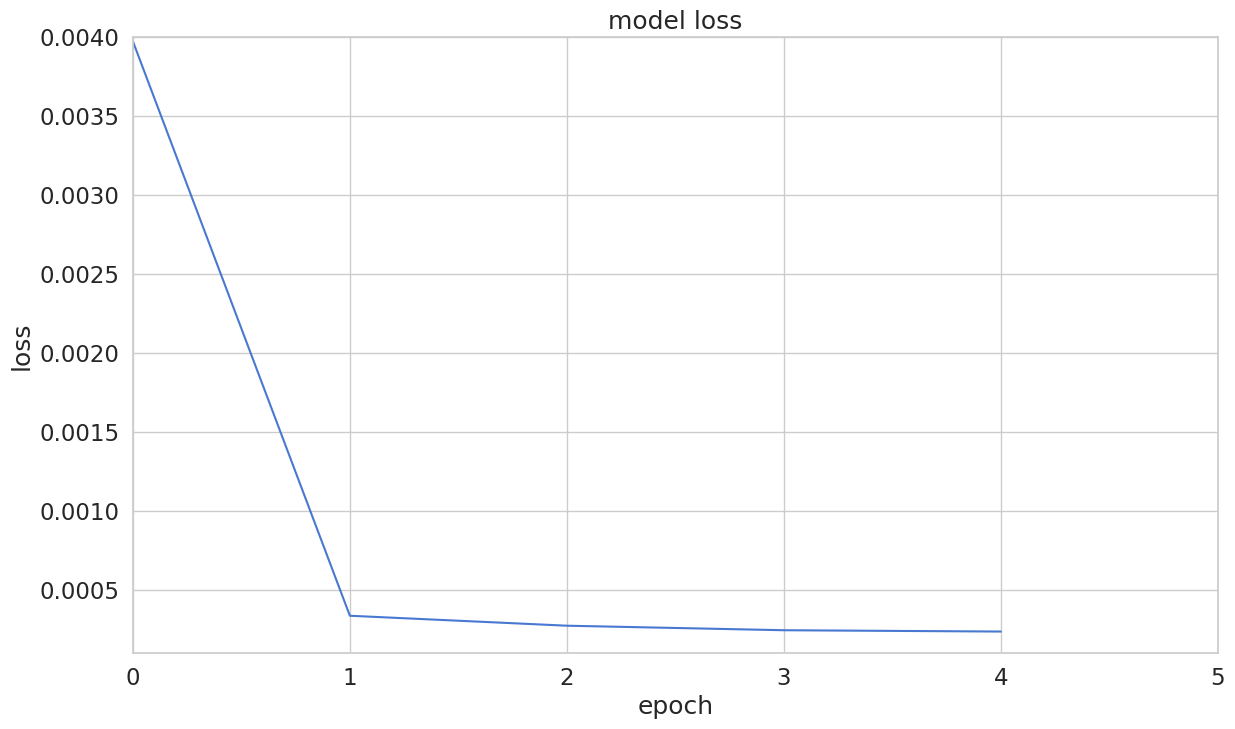

In [26]:
plt.plot(history['train_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.axis([0,5,0.0001,0.004])
plt.show()

# Оценка модели

In [27]:
pred_losses = {'pred_loss' : []} # Ошибки
model.eval() # переводит модель в режим оценки
with torch.no_grad():
    for data in test_loader:
        inputs = data
        outputs = model(inputs)
        loss = criterion(outputs, inputs).data.item() # Ошибка реконструкция
        pred_losses['pred_loss'].append(loss)
reconstructionErrorDF = pd.DataFrame(pred_losses)
reconstructionErrorDF[48] = y_test
# В результатах будет DataFrame, где каждый пример тестовых данных будет иметь ошибку реконструкции и соответствующую метку класса.

In [28]:
reconstructionErrorDF.head(50)

,pred_loss,48
0,0.000089,0
1,0.000224,0
2,0.000050,0
3,0.000150,0
4,0.000140,0
5,0.000079,0
6,0.000395,0
7,0.000016,0
8,0.000198,0
9,0.000284,0


In [29]:
reconstructionErrorDF['pred_loss'][reconstructionErrorDF[48] == 0].describe()

,pred_loss
count,1.354370e+05
mean,2.348423e-04
std,1.069266e-03
min,2.708879e-07
25%,2.744772e-05
50%,8.084902e-05
75%,1.673509e-04
max,1.132662e-01


In [30]:
reconstructionErrorDF['pred_loss'][reconstructionErrorDF[48] == 1].describe()

,pred_loss
count,4563.000000
mean,0.008174
std,0.021855
min,0.000563
25%,0.001554
50%,0.002486
75%,0.004939
max,0.169930


Можем заметить, что средняя ошибка в классе 0 на порядок меньше чем в классе 1

In [ ]:
reconstructionErrorDF.describe()

,pred_loss,48
count,140000.000000,140000.000000
mean,0.000262,0.032593
std,0.001428,0.177569
min,0.000001,0.000000
25%,0.000018,0.000000
50%,0.000043,0.000000
75%,0.000116,0.000000
max,0.160300,1.000000


(0.0, 0.001)

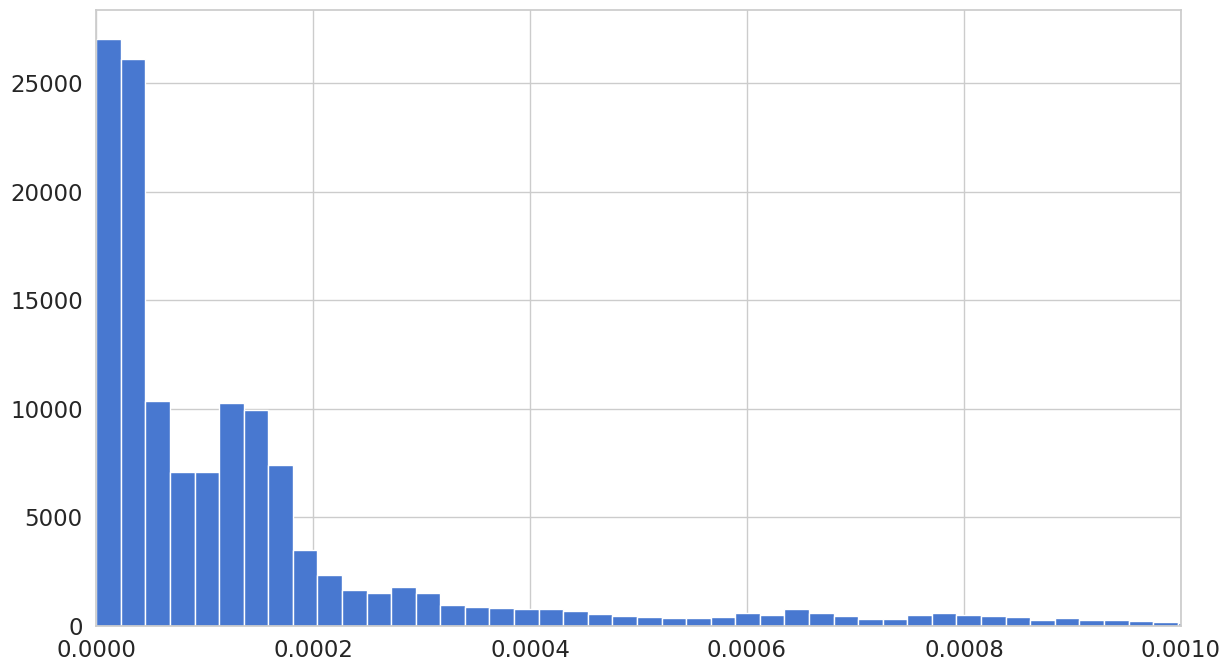

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = reconstructionErrorDF[(reconstructionErrorDF[48]== 0)]
_ = ax.hist(normal_error_df.pred_loss.values, bins=5000)
ax.set_xlim(0, 0.001)



(0.0, 0.01)

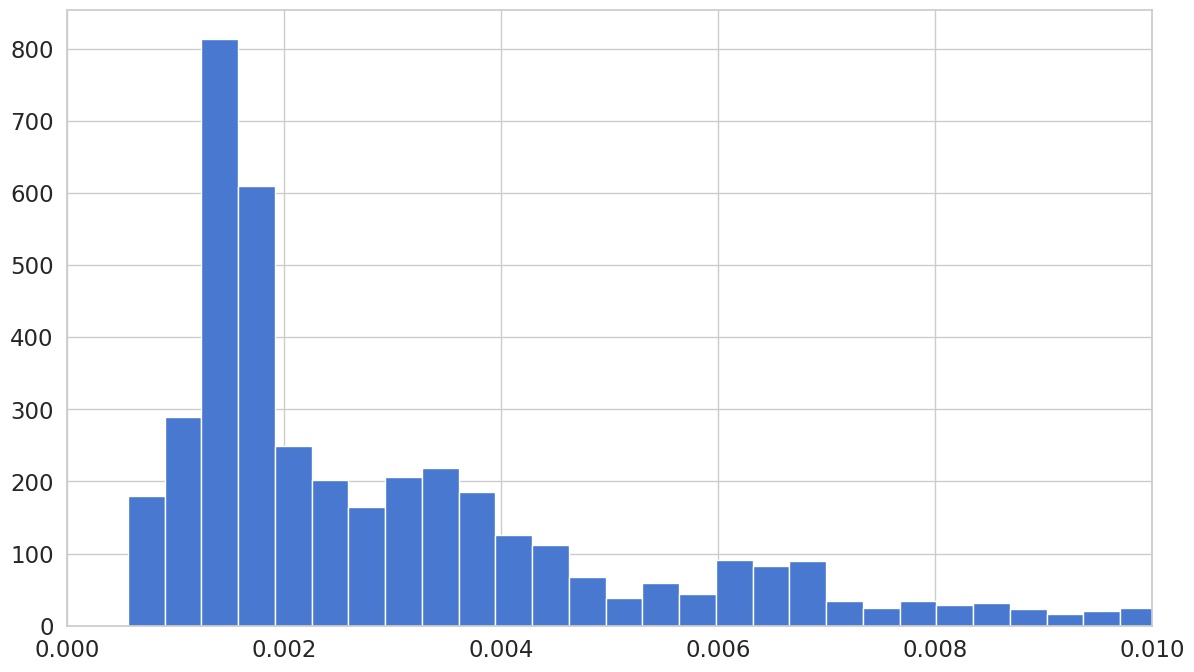

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = reconstructionErrorDF[(reconstructionErrorDF[48]== 1)]
_ = ax.hist(normal_error_df.pred_loss.values, bins=500)
ax.set_xlim(0, 0.01)

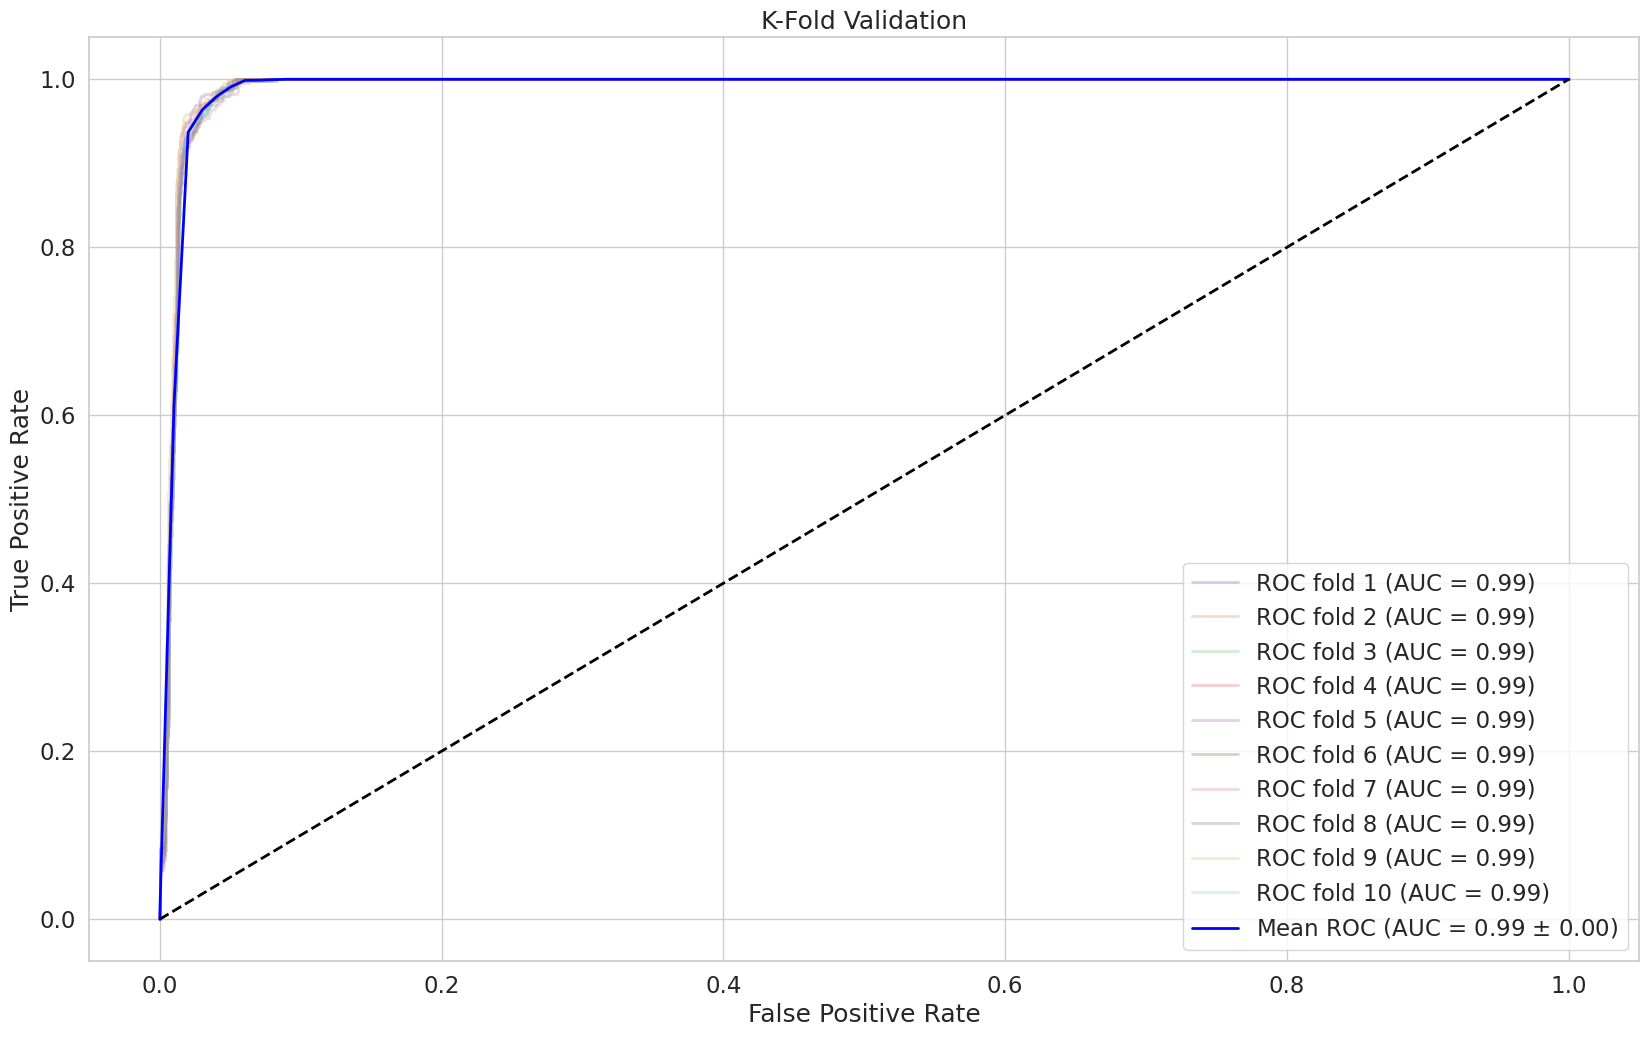

In [34]:
# Построение ROC-кривых
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
tprs, aucs = [], []
mean_fpr = np.linspace(0, 1, 100)

fig = plt.figure(figsize=(20, 12), dpi=100)
i = 1

for train_idx, test_idx in cv.split(X_test, y_test):
    X_test_fold = X_test[test_idx]
    y_test_fold = y_test[test_idx]

    # Рассчитываем ошибки реконструкции для тестовой выборки
    model.eval()
    reconstruction_errors = []
    with torch.no_grad():
        for data in X_test_fold:
            data = torch.tensor(data).unsqueeze(0).float()
            outputs = model(data)
            loss = criterion(outputs, data).item()
            reconstruction_errors.append(loss)

    # Строим ROC-кривую
    fpr, tpr, thresholds = roc_curve(y_test_fold, reconstruction_errors, pos_label=1)
    roc_auc = auc(fpr, tpr)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label=f'ROC fold {i} (AUC = {roc_auc:.2f})')
    i += 1

# Средние значения и доверительный интервал
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f $±$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=1)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K-Fold Validation')
plt.legend(loc="lower right")
plt.show()

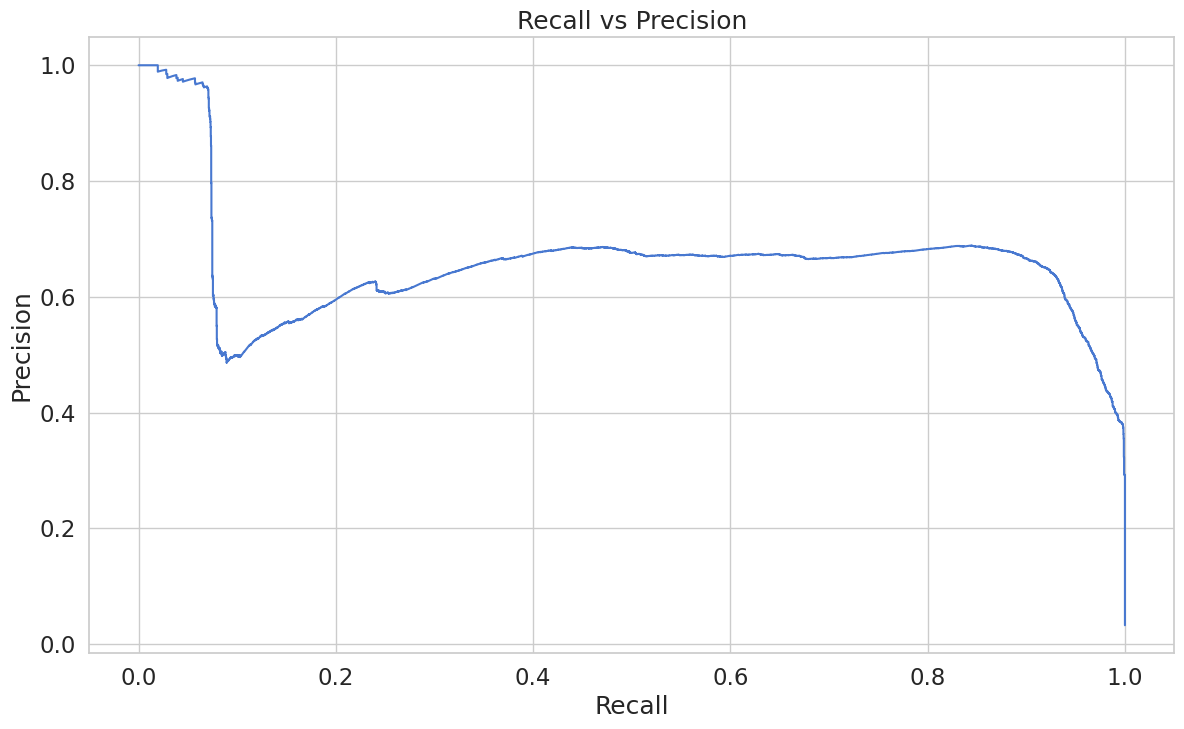

In [35]:
precision, recall, th = precision_recall_curve(reconstructionErrorDF[48], reconstructionErrorDF.pred_loss)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

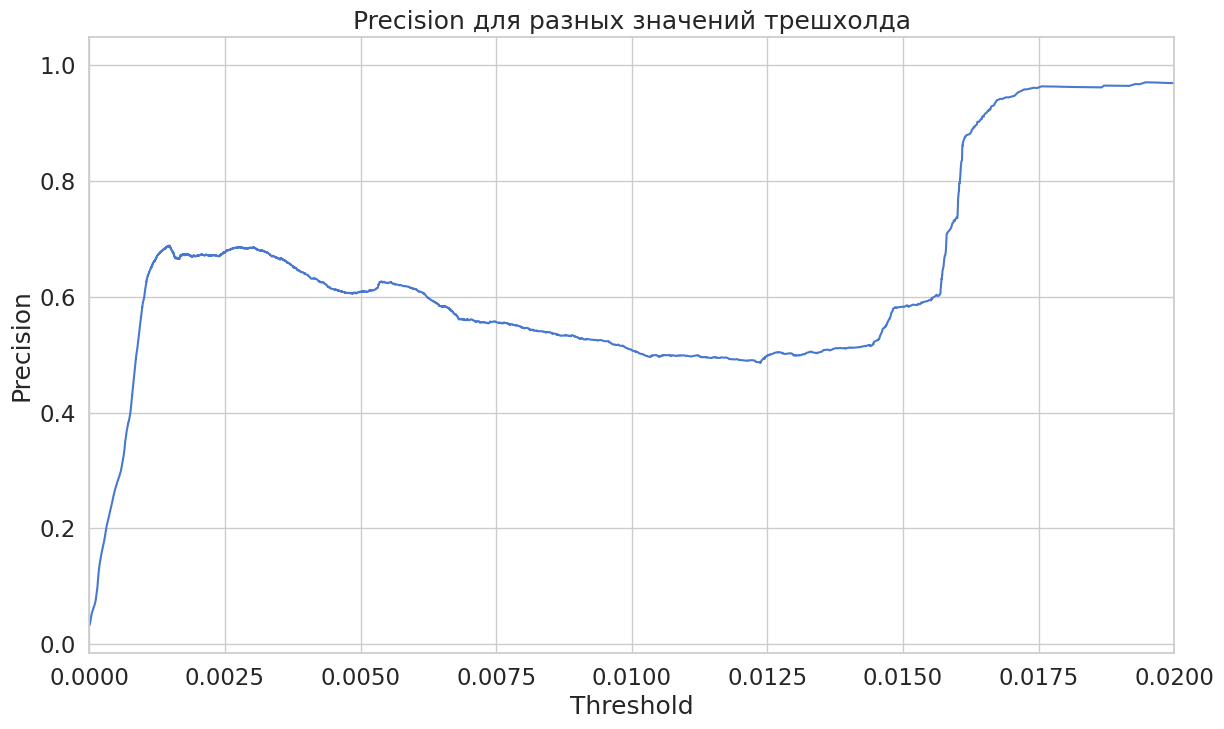

In [36]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision для разных значений трешхолда')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.xlim(0, 0.02)
plt.show()

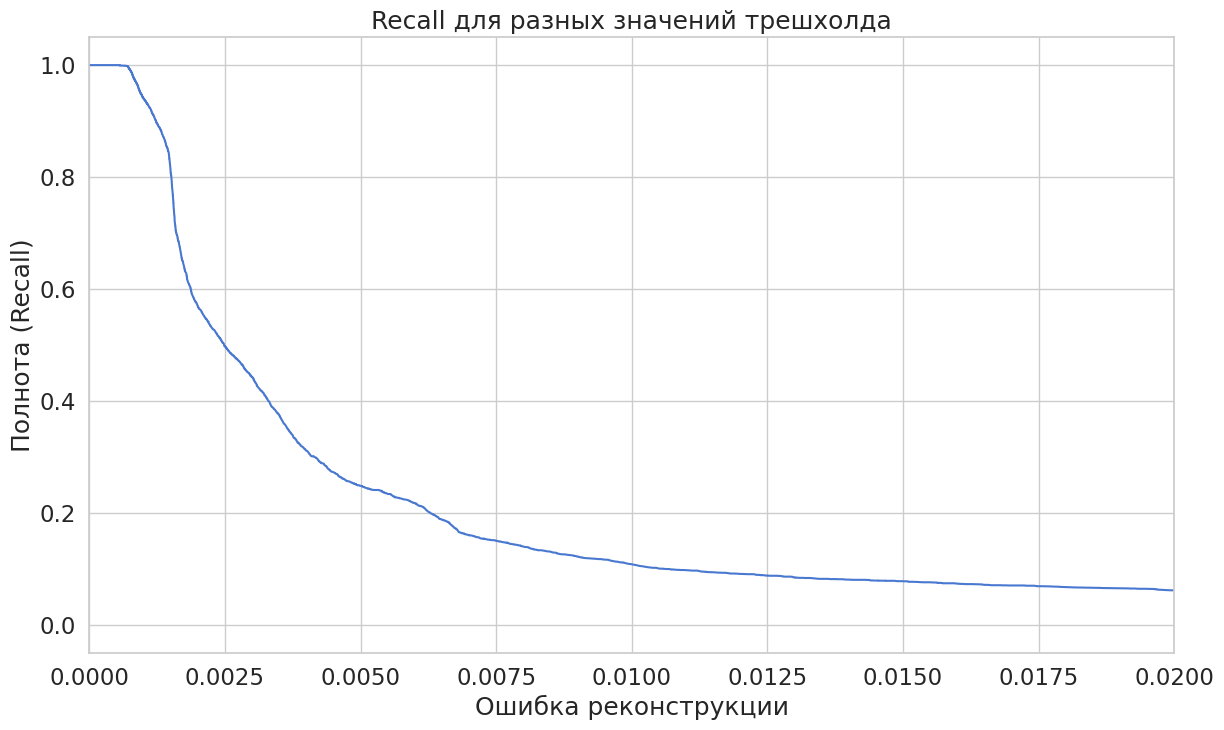

In [37]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall для разных значений трешхолда')
plt.xlabel('Ошибка реконструкции')
plt.ylabel('Полнота (Recall)')
plt.xlim(0, 0.02)
plt.show()

Используем модель для того, чтобы сделать предсказание

In [77]:
threshold = 0.00056

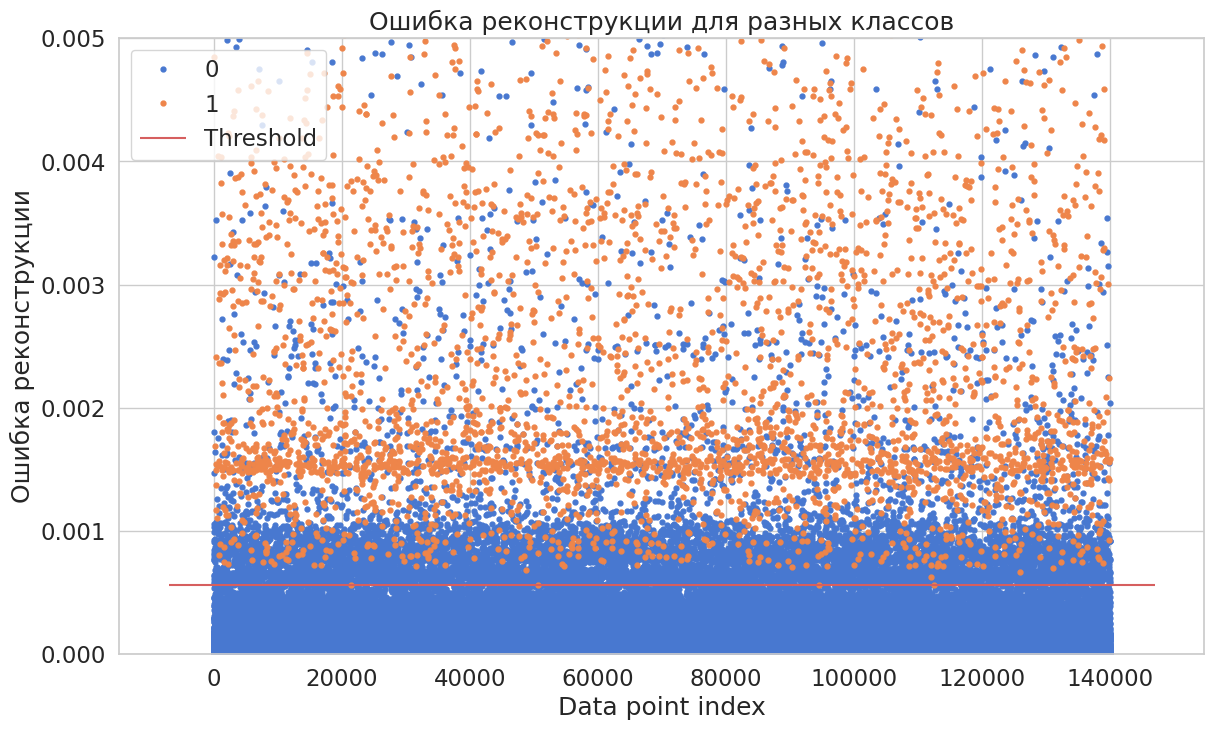

In [78]:
groups = reconstructionErrorDF.groupby(48)
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.pred_loss, marker='o', ms=3.5, linestyle='',
            label= "1" if name == 1 else "0")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Ошибка реконструкции для разных классов")
plt.ylabel("Ошибка реконструкции")
plt.xlabel("Data point index")
plt.ylim(0, 0.005)
plt.show();

In [79]:
# Вычисляем матрицу корреляций
corr_matrix = df.copy()
plt.figure(figsize=(25,12),dpi=100)

corr_matrix = corr_matrix.corr(method="pearson")

<Figure size 2500x1200 with 0 Axes>

<ipython-input-80-49fa6ee6e320>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Blues'));


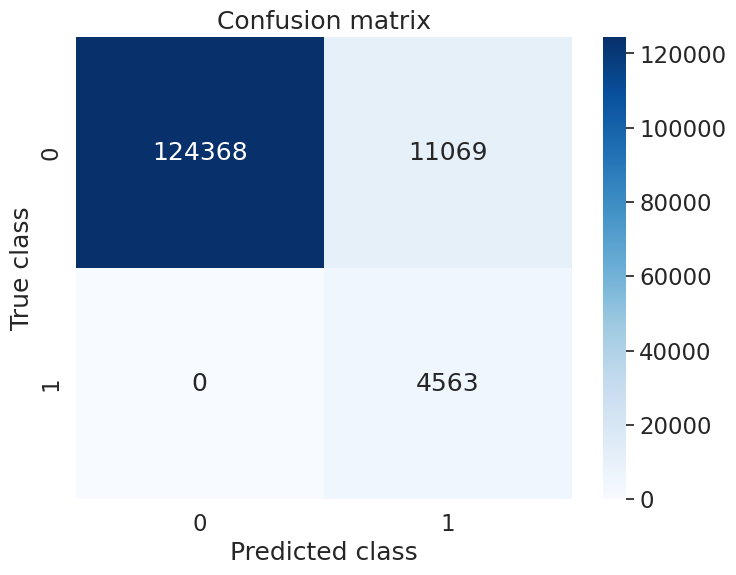

In [80]:
y_pred = [1 if e > threshold else 0 for e in reconstructionErrorDF.pred_loss.values]
conf_matrix = confusion_matrix(reconstructionErrorDF[48], y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, xticklabels=[0, 1], yticklabels=[0, 1], annot=True, fmt="d",
            cmap=plt.cm.get_cmap('Blues'));
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [82]:
print(f'Точность предсказания вредоносного трафика - {(conf_matrix[1, 1]) / float(conf_matrix[1, 0] + conf_matrix[1, 1])}')
print(f'Точность предсказания нормального трафика - {(conf_matrix[0, 0]) / float(conf_matrix[0, 1] + conf_matrix[0, 0])}')

Точность предсказания вредоносного трафика - 1.0
Точность предсказания нормального трафика - 0.9182719640866233


Построен и обучен автоэнкодер который может с высокой точностю определить вредоносный трафик